# [シンプルな音声認識：キーワードの認識]()

In [40]:
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Download dataset

In [41]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file('mini_speech_commands.zip', origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
                           extract=True, cache_dir='.', cache_subdir='data')
    
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print(commands)
commands = commands[commands != 'README.md']
print(commands)

['right' 'stop' 'go' 'left' 'yes' 'up' 'no' 'down' 'README.md']
['right' 'stop' 'go' 'left' 'yes' 'up' 'no' 'down']


In [42]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print(f'num_samples: {num_samples}')
print('Example file tensor:', filenames[0])

train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print(train_files[0])

num_samples: 8000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/yes/b00dff7e_nohash_0.wav', shape=(), dtype=string)
tf.Tensor(b'data/mini_speech_commands/yes/b00dff7e_nohash_0.wav', shape=(), dtype=string)


In [43]:
def decode_audio(audio_binary):
    # audio is a tensor of type float32
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    # squeeze: removes dimensions of size 1 from the shape of a tensor
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    # split data with '/'. See below as an exaple
    # b'data/mini_speech_commands/no/798f702a_nohash_0.wav' --> b'no'
    # parts[-1] = 798f702a_nohash_0.wav
    # parts[-2] = no
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

# Visualize audio waveform

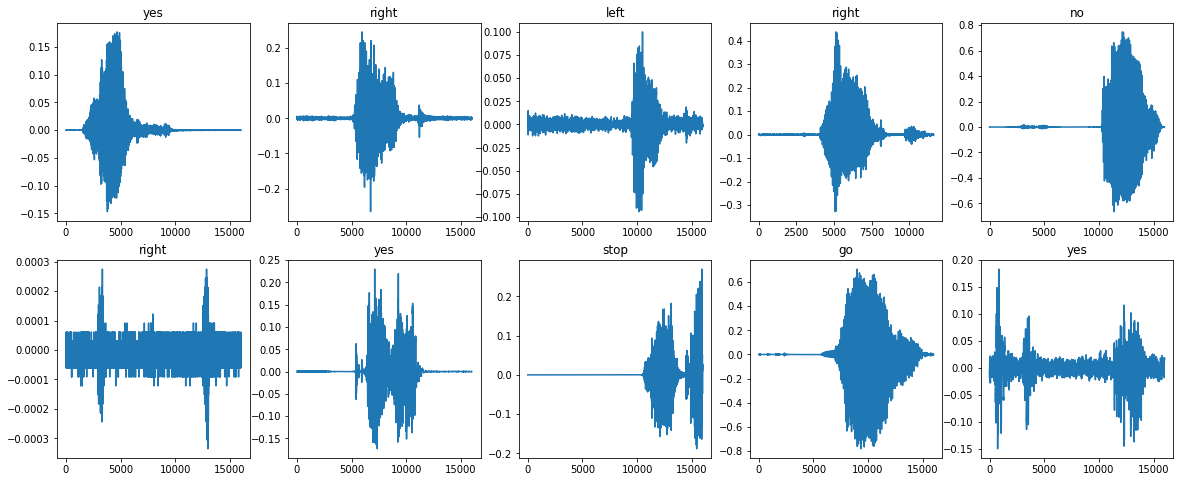

In [44]:
fig = plt.figure(figsize=(20,8))

for i, (audio, label) in enumerate(waveform_ds.take(10)):
    fig.add_subplot(2,5, i+1)
    plt.plot(audio.numpy())
    plt.title(label.numpy().decode('utf-8'))

# Short Time Fourier Transform
### Point
- tf.signal.fft drops time information
- tf.signal.stft keeps time information

In [45]:
def get_spectrogram(waveform):
    # Fix samples number to 16000
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], axis=0)
    
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    
    return spectrogram
    

for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label', label)
print('Waveform Shape', waveform.shape)
print('Spectrogram Shape', spectrogram.shape)
display.display(display.Audio(waveform, rate=16000))

Label yes
Waveform Shape (16000,)
Spectrogram Shape (124, 129)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


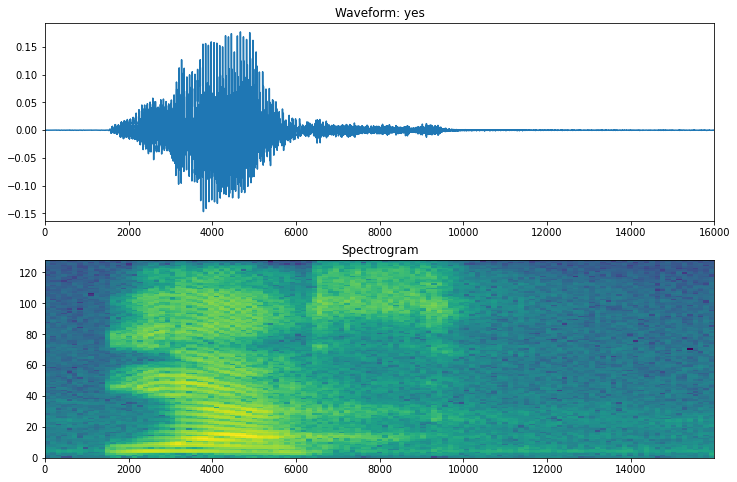

In [46]:
def plot_spectrogram(spectrogram, ax):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform: ' + label)
axes[0].set_xlim([0,16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [47]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

# Modeling

In [48]:
def preprocess_dataset(files):
    # Create dataset from tensor using from_tensor_slices
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    
    return output_ds


train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size=64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [51]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    num_labels = len(commands)
    
model = keras.Sequential()
model.add(keras.layers.Input(shape=input_shape))
model.add(keras.layers.experimental.preprocessing.Resizing(32,32))
model.add(keras.layers.experimental.preprocessing.Normalization())
model.add(keras.layers.Conv2D(32, 3, activation='relu'))
model.add(keras.layers.Conv2D(64, 3, activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_labels))

model.summary()

model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-5), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

EPOCHS=100

history = model.fit(train_ds, validation_data = val_ds, epochs=EPOCHS, callbacks=keras.callbacks.EarlyStopping(verbose=-1, patience=10))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_9 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_8 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 12544)           

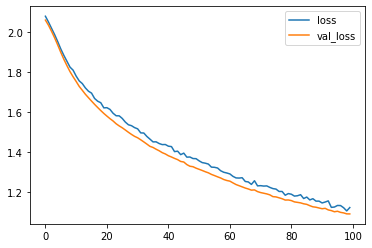

In [52]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()